## Automobile Customer Segmentation - KMeans Clustering

In [77]:
#importing necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.decomposition import PCA

### Know Your Data -

In [2]:
df=pd.read_csv('train-set.csv')
df.drop('Segmentation',axis=1,inplace=True) #segmentation is a target column, we dont need it for clustering
df.head()

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Category 4
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Category 4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Category 6
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Category 6
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Category 6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      8068 non-null   int64  
 1   Gender          8068 non-null   object 
 2   Married         7928 non-null   object 
 3   Age             8068 non-null   int64  
 4   Graduated       7990 non-null   object 
 5   Profession      7944 non-null   object 
 6   WorkExperience  7239 non-null   float64
 7   SpendingScore   8068 non-null   object 
 8   FamilySize      7733 non-null   float64
 9   Category        7992 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 630.4+ KB


In [4]:
#look for missing values
df.isnull().sum()

CustomerID          0
Gender              0
Married           140
Age                 0
Graduated          78
Profession        124
WorkExperience    829
SpendingScore       0
FamilySize        335
Category           76
dtype: int64

In [5]:
#getting missing values
nan_val=df.isnull() 
nan_rows=nan_val.any(axis=1) #geting rows which are having missing values
df_missing=df[nan_rows] #slicing missing values from our main dataframe
df_missing

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Category 4
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Category 6
12,461230,Female,No,19,No,Executive,0.0,Low,NaN,Category 3
13,459573,Male,Yes,70,No,Lawyer,NaN,Low,1.0,Category 6
24,461021,Female,NaN,58,No,Executive,1.0,Average,3.0,Category 3
...,...,...,...,...,...,...,...,...,...,...
8040,467165,Female,No,25,No,Homemaker,NaN,Low,1.0,Category 6
8044,466997,Female,NaN,50,No,Engineer,1.0,Low,2.0,Category 6
8047,462396,Male,Yes,50,Yes,Doctor,NaN,Average,2.0,Category 6
8049,461292,Female,Yes,81,No,Lawyer,NaN,High,2.0,Category 3


We can observe here, total missing values are in 1403 rows.

### Fill 'Unknown' for the missing values in the data

In [6]:
df=df.fillna('Unknown')

## Visualise the data - 

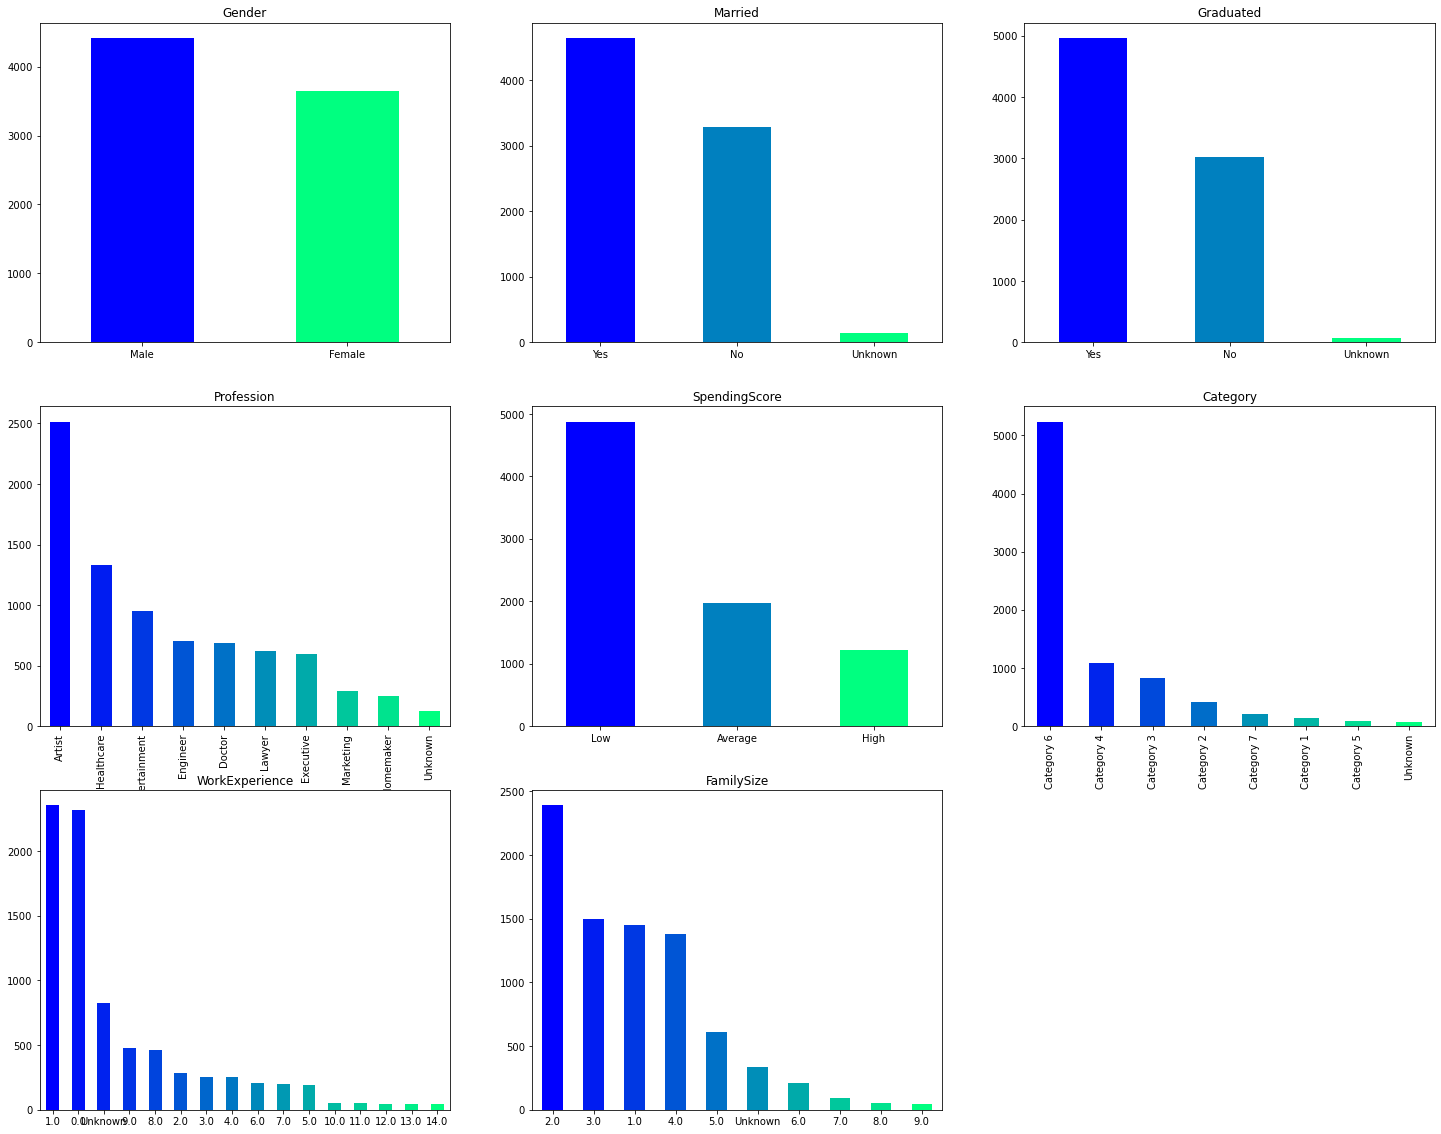

In [7]:
fig=plt.figure(figsize=(25,20)) #figuresize
def plot_stats(fig,subplot_id,column,color_map,rotation): #define function that plots a graph for categorical features when passed inputs.
    fig.add_subplot(subplot_id) #subplot id=location of plot in the figure (331 = 3x3 figure & 1st plot, 335 = 331 = 3x3 figure & 5th plot)
    
    color_len=len(df[column].unique())   
    color=color_map(np.linspace(0,1,color_len))
    
    class_count=df[column].value_counts() 
    class_count.plot(kind='bar',color=color)
    plt.title(column)
    plt.xticks(rotation=rotation)

#plotting figures using define function-    
plot_stats(fig,331,'Gender',plt.cm.winter,'horizontal')
plot_stats(fig,332,'Married',plt.cm.winter,'horizontal')
plot_stats(fig,333,'Graduated',plt.cm.winter,'horizontal')
plot_stats(fig,334,'Profession',plt.cm.winter,'vertical')
plot_stats(fig,335,'SpendingScore',plt.cm.winter,'horizontal')
plot_stats(fig,336,'Category',plt.cm.winter,'vertical')
plot_stats(fig,337,'WorkExperience',plt.cm.winter,'horizontal')
plot_stats(fig,338,'FamilySize',plt.cm.winter,'horizontal')


### Creating age band to analyse the age distribution in Gender

In [8]:
df1=df.copy() #make a copy of original data & user copied

In [9]:
#creat age band in 7 bands
age_band=pd.cut(df1['Age'],bins=7)

In [10]:
#grouping the data on the basis of age band & categories
grouped=df1.groupby(['Gender',age_band]).size().reset_index(name='Count')
grouped

,Gender,Age,Count
0,Female,"(17.929, 28.143]",729
1,Female,"(28.143, 38.286]",960
2,Female,"(38.286, 48.429]",835
3,Female,"(48.429, 58.571]",511
4,Female,"(58.571, 68.714]",270
5,Female,"(68.714, 78.857]",188
6,Female,"(78.857, 89.0]",158
7,Male,"(17.929, 28.143]",918
8,Male,"(28.143, 38.286]",1000
9,Male,"(38.286, 48.429]",905


In [11]:
#creating seperate dataframe for male & female data
group1=grouped['Gender']=='Female'
group2=grouped['Gender']=='Male'

df1_sliced1=grouped.loc[group1]
df1_sliced2=grouped.loc[group2]

In [12]:
df1_sliced1

,Gender,Age,Count
0,Female,"(17.929, 28.143]",729
1,Female,"(28.143, 38.286]",960
2,Female,"(38.286, 48.429]",835
3,Female,"(48.429, 58.571]",511
4,Female,"(58.571, 68.714]",270
5,Female,"(68.714, 78.857]",188
6,Female,"(78.857, 89.0]",158


<AxesSubplot:title={'center':'Male'}, xlabel='Age'>

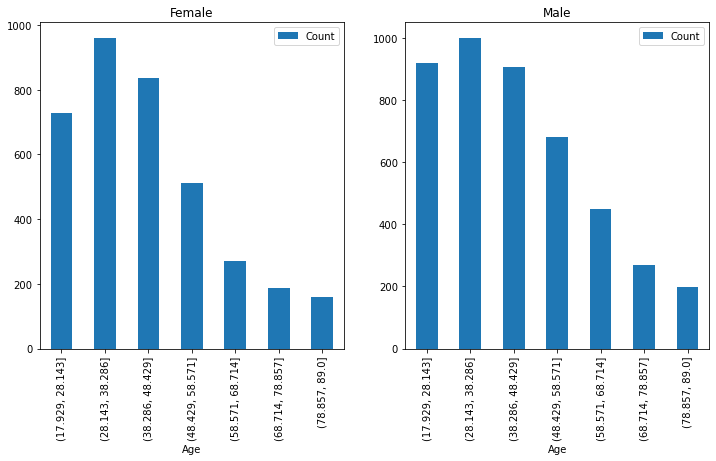

In [13]:
#bar plot of male & female data based on age band & count

fig,axis=plt.subplots(nrows=1,ncols=2,figsize=(12,6))

df1_sliced1.plot(x='Age',y='Count',kind='bar',title='Female',ax=axis[0])
df1_sliced2.plot(x='Age',y='Count',kind='bar',title='Male',ax=axis[1])

## Label Encoding of Categorical Values - 

In [14]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [15]:
df1

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Category 4
1,462643,Female,Yes,38,Yes,Engineer,Unknown,Average,3.0,Category 4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Category 6
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Category 6
4,462669,Female,Yes,40,Yes,Entertainment,Unknown,High,6.0,Category 6
...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,Unknown,0.0,Low,7.0,Category 1
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Category 4
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Category 6
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Category 6


In [16]:
list=['Gender','Married','Graduated','Profession','SpendingScore','Category']
#Label Encoder on above listed columns
for i in list:
    le.fit(df1[i])
    df1[i]=le.transform(df1[i])
df1

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,462809,1,0,22,0,5,1.0,2,4.0,3
1,462643,0,2,38,2,2,Unknown,0,3.0,3
2,466315,0,2,67,2,2,1.0,2,1.0,5
3,461735,1,2,67,2,7,0.0,1,2.0,5
4,462669,0,2,40,2,3,Unknown,1,6.0,5
...,...,...,...,...,...,...,...,...,...,...
8063,464018,1,0,22,0,9,0.0,2,7.0,0
8064,464685,1,0,35,0,4,3.0,2,4.0,3
8065,465406,0,0,33,2,5,1.0,2,1.0,5
8066,467299,0,0,27,2,5,1.0,2,4.0,5


### Replace unknown values from 'WorkExperience' & 'FamilySize' into mode

In [17]:
#mode
df1['WorkExperience'].mode()[0]

1.0

In [18]:
#replace unknown values with mode
df1['WorkExperience']=df1['WorkExperience'].replace('Unknown',df1['WorkExperience'].mode()[0])
df1['FamilySize']=df1['FamilySize'].replace('Unknown',df1['FamilySize'].mode()[0])

In [19]:
df1.isnull().sum()

CustomerID        0
Gender            0
Married           0
Age               0
Graduated         0
Profession        0
WorkExperience    0
SpendingScore     0
FamilySize        0
Category          0
dtype: int64

In [20]:
#drop CustomerID
df1=df1.drop('CustomerID',axis=1)

## Normalization of the data -

In [21]:
norm_data=df1.copy()

In [22]:
#min-max scaler
scaler=MinMaxScaler()

In [23]:
normed_data=scaler.fit_transform(norm_data)

In [24]:
normed_data=pd.DataFrame(data=normed_data,columns=norm_data.columns)

In [25]:
normed_data

,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,1.0,0.0,0.056338,0.0,0.555556,0.071429,1.0,0.375,0.428571
1,0.0,1.0,0.281690,1.0,0.222222,0.071429,0.0,0.250,0.428571
2,0.0,1.0,0.690141,1.0,0.222222,0.071429,1.0,0.000,0.714286
3,1.0,1.0,0.690141,1.0,0.777778,0.000000,0.5,0.125,0.714286
4,0.0,1.0,0.309859,1.0,0.333333,0.071429,0.5,0.625,0.714286
...,...,...,...,...,...,...,...,...,...
8063,1.0,0.0,0.056338,0.0,1.000000,0.000000,1.0,0.750,0.000000
8064,1.0,0.0,0.239437,0.0,0.444444,0.214286,1.0,0.375,0.428571
8065,0.0,0.0,0.211268,1.0,0.555556,0.071429,1.0,0.000,0.714286
8066,0.0,0.0,0.126761,1.0,0.555556,0.071429,1.0,0.375,0.714286


## Clustering - 

In [32]:
kmean=KMeans(max_iter=1000,n_clusters=5)

In [33]:
kmean.fit(normed_data)
labels=kmean.predict(normed_data)
print('Labels - ',labels)

lab_count=np.bincount(labels)
print('Label Count - ',lab_count)

centroid=kmean.cluster_centers_
print('Centroids - ',centroid)

Labels -  [2 1 1 ... 3 3 0]
Label Count -  [1939 1384 1649 1694 1402]
Centroids -  [[1.00000000e+00 9.92260062e-01 4.67012602e-01 9.94582043e-01
  2.55704621e-01 1.56678461e-01 4.46336429e-01 2.10977812e-01
  6.26492702e-01]
 [1.99840144e-15 9.93497110e-01 4.75972889e-01 9.93858382e-01
  2.29608221e-01 1.67320396e-01 4.29190751e-01 1.98970376e-01
  6.11890999e-01]
 [5.17889630e-01 1.09157065e-02 1.30476003e-01 6.36749545e-03
  4.68162523e-01 1.76254007e-01 9.99090358e-01 3.13978169e-01
  5.47171446e-01]
 [4.37426210e-01 6.49350649e-03 2.67996408e-01 9.97048406e-01
  2.67611177e-01 2.26935402e-01 1.00000000e+00 1.72151712e-01
  6.02378141e-01]
 [6.30078403e-01 9.87883108e-01 4.71093130e-01 3.20741269e-03
  3.90433199e-01 1.53141228e-01 4.88595866e-01 2.39932288e-01
  5.83138173e-01]]


In [34]:
result_data=normed_data.copy()
result_data['Clusters']=labels
result_data.insert(0,'CustomerID',df['CustomerID'])
result_data

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category,Clusters
0,462809,1.0,0.0,0.056338,0.0,0.555556,0.071429,1.0,0.375,0.428571,2
1,462643,0.0,1.0,0.281690,1.0,0.222222,0.071429,0.0,0.250,0.428571,1
2,466315,0.0,1.0,0.690141,1.0,0.222222,0.071429,1.0,0.000,0.714286,1
3,461735,1.0,1.0,0.690141,1.0,0.777778,0.000000,0.5,0.125,0.714286,0
4,462669,0.0,1.0,0.309859,1.0,0.333333,0.071429,0.5,0.625,0.714286,1
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,1.0,0.0,0.056338,0.0,1.000000,0.000000,1.0,0.750,0.000000,2
8064,464685,1.0,0.0,0.239437,0.0,0.444444,0.214286,1.0,0.375,0.428571,2
8065,465406,0.0,0.0,0.211268,1.0,0.555556,0.071429,1.0,0.000,0.714286,3
8066,467299,0.0,0.0,0.126761,1.0,0.555556,0.071429,1.0,0.375,0.714286,3


### Visualization of Clusters

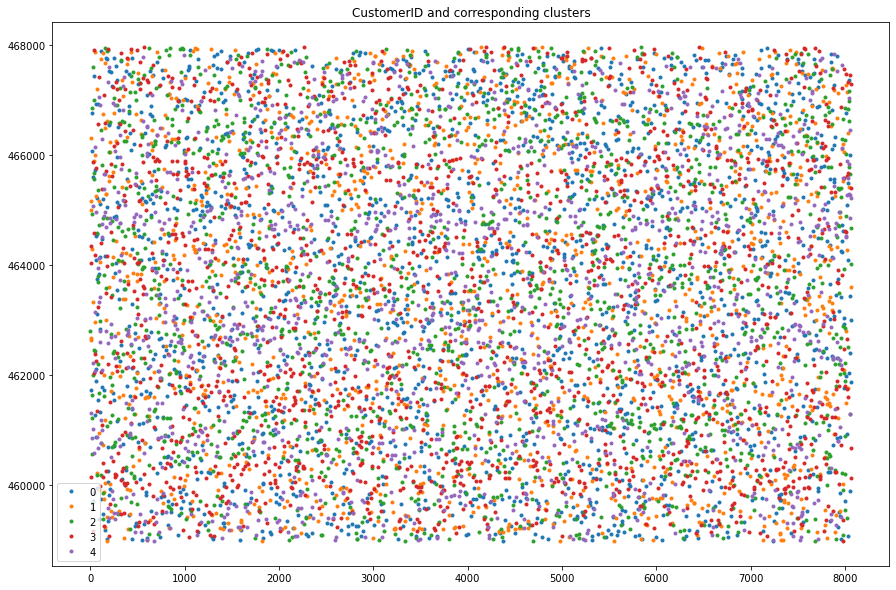

In [35]:
u_labels = np.unique(labels)
plt.figure(figsize=(15,10))
for i in u_labels:
    mask = (result_data["Clusters"] == i)    
    plt.plot(result_data[mask]["CustomerID"], ".", label = i)
plt.title('CustomerID and corresponding clusters')
plt.legend(loc='best')

## PCA - 

In [89]:
pca=PCA(n_components=2)

In [90]:
pca_data=pca.fit_transform(normed_data)

In [91]:
kmean=KMeans(max_iter=5000,random_state=85,n_clusters=5)
labels1=kmean.fit_predict(pca_data)

In [92]:
pca_data=pd.DataFrame(data=pca_data)
pca_data['CustomerID']=df['CustomerID']
pca_data['Clusters']=labels1
pca_data

,0,1,CustomerID,Clusters
0,0.839446,0.689575,462809,4
1,-0.699226,-0.612266,462643,0
2,-0.270571,-0.661440,466315,0
3,-0.618940,0.293967,461735,2
4,-0.426060,-0.587977,462669,0
...,...,...,...,...
8063,0.925306,0.779318,464018,4
8064,0.790462,0.665538,464685,4
8065,0.573017,-0.680870,465406,1
8066,0.600113,-0.653749,467299,1


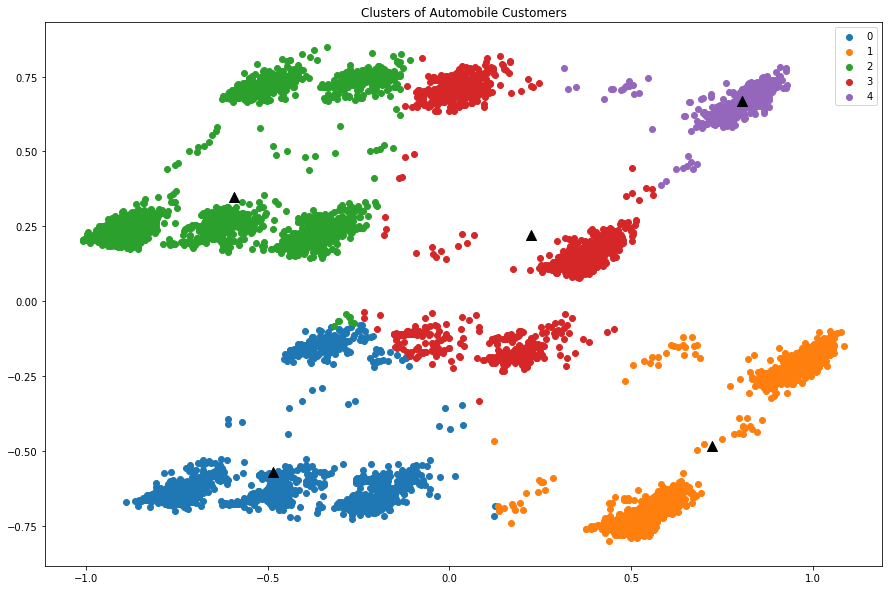

In [93]:
u_labels=np.unique(labels1)
centroids=kmean.cluster_centers_

plt.figure(figsize=(15,10))
for i in u_labels:
    mask = (pca_data["Clusters"] == i)
    plt.scatter(pca_data.loc[mask][0], pca_data.loc[mask][1], label = i)
    
    
plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'k', marker="^")   
plt.title('Clusters of Automobile Customers')
plt.legend()

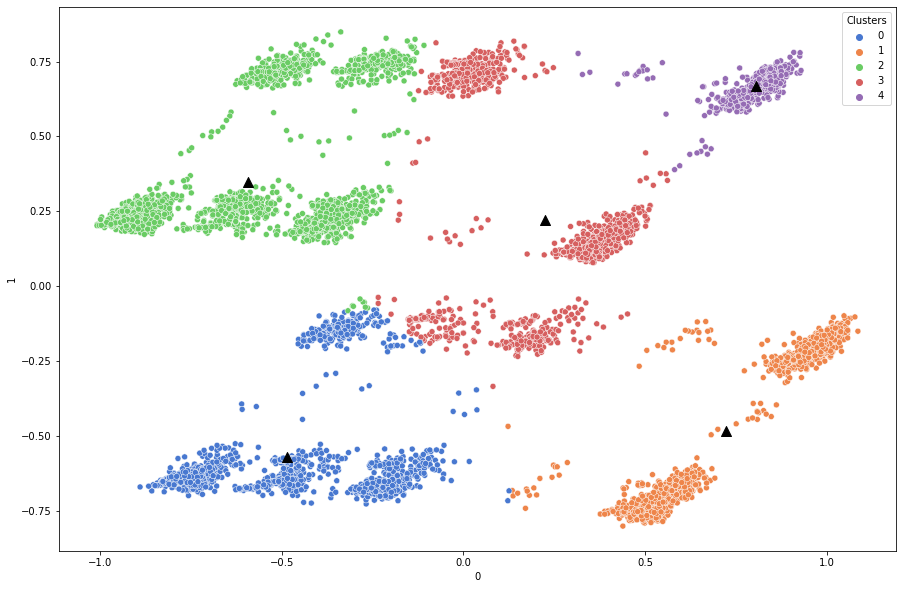

In [94]:
#plot
plt.figure(figsize=(15,10))
sns.scatterplot(x=pca_data[0],y=pca_data[1],hue=pca_data['Clusters'],palette='muted')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'k', marker="^") 